In [1]:
import os
import pandas as pd

import sys
from datetime import datetime
sys.path.append('../../Scripts')

from preprocess_daily import DailyPreprocessor

from generate_signals import SignalGenerator


# 단위테스트

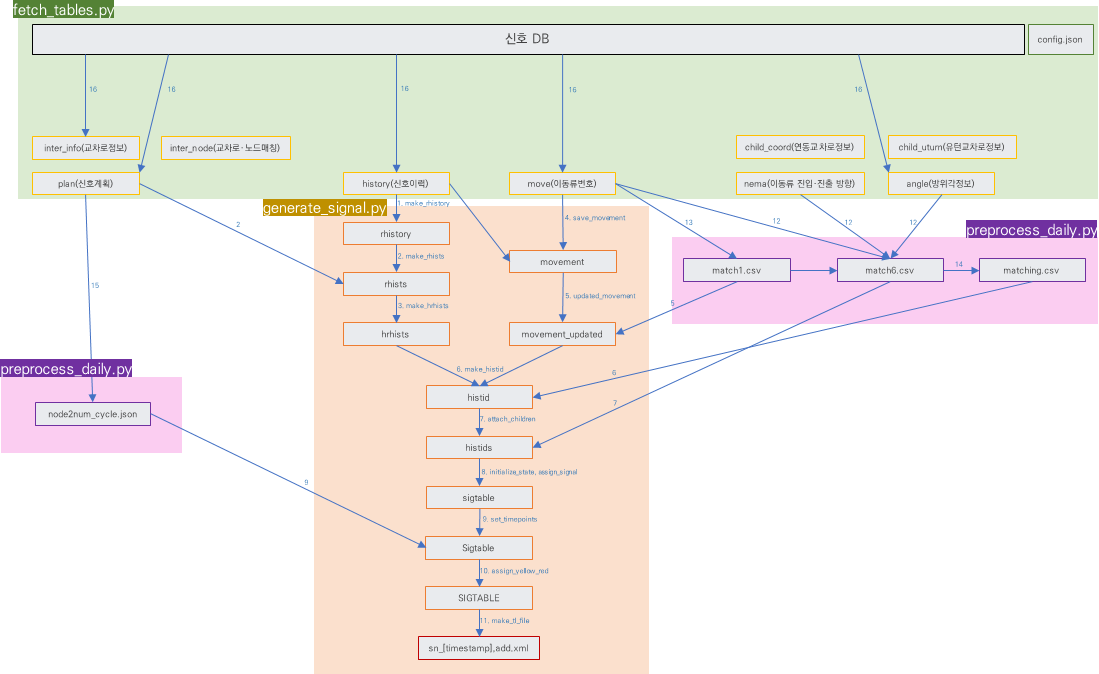

## 1. `make_rhistory`

### 1.1. 입력데이터
- 입력
  - 프로젝트 진행시 입력데이터 : 신호이력에 대한 쿼리
  - 현재 입력데이터 : `history.csv`(하루치의 신호이력)
- 컬럼 : 교차로번호, 종료유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 옵셋

In [2]:
self = SignalGenerator()
# 1. 데이터 준비
self.prepare_data()
self.history.head()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.


Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
0           0       206  1704380520       33       35       26       26   
1           1       202  1704380539       39      101        0        0   
2           2       178  1704380540       38       39       40       23   
3           3       201  1704380540       24       24       17       58   
4           4       177  1704380550       36       20       68       26   

   dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
0        0        0        0  ...       33       35       26       26   
1        0        0        0  ...       39      101        0        0   
2        0        0        0  ...       38       39       40       23   
3       17        0        0  ...       24       24       17       58   
4        0        0        0  ...       36       20       68       26   

   dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
0        0        0        0        0    120      10  
1        0        0        0        0    140     103  
2        0        0        0        0    140      50  
3       17        0        0        0    140     133  
4        0        0        0        0    150      35  

[5 rows x 21 columns]

### 1.2 출력 데이터
- 출력 : `rhistory`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기
- 설명 : 신호이력 로드, 슬라이싱(30분, 10분), 종료유닉스를 시작유닉스로 변경 등

In [3]:
self.make_rhistory()
self.rhistory.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1882       175  1704415950       43       45       55       37        0   
1884       177  1704415979       43       27       70       40        0   
1883       206  1704416010       45       53       26       26        0   
1885       178  1704416010       38       39       43       50        0   
1886       176  1704415999       37      103       40        0        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1882        0        0        0       43       45       33       59        0   
1884        0        0        0       43       27       70       40        0   
1883        0        0        0       45       53       26       26        0   
1885        0        0        0       38       39       71       22        0   
1886        0        0        0       37      103       40        0        0   

      dura_B6  dura_B7  dura_B8  cycle  
1882        0        0        0    180  
1884        0        0        0    180  
1883        0        0        0    150  
1885        0        0        0    170  
1886        0        0        0    180

### 1.3 검증요건
1. 현재시점으로부터 `substractor`(30분) 동안의 신호이력 로드되었는가?
2. 현재시점 + `adder`(10분)에 한 주기가 신호 추가되었는가?
3. 종료유닉스가 시작유닉스로 잘 변환되었는가?
   - 이전 종료유닉스가 존재하지 않으면 현재 종료유닉스로부터 현시시간 합의 차로 한다.
   - 이전 종료유닉스가 존재하면 abs < 10인 경우 이전 종료유닉스로 하고, abs > 10인 경우 현시시간 합의 차로 한다.
4. 존재하지 않는 교차로에 대하여 한 주기 신호 추가되었는가?

### 1.4 검증

In [4]:
# 1 : 약 30분(1800초) 동안의 신호이력이 로드되었음
# 2 : 현재시점으로부터 약 10분(600초)이 경과한 시점까지의 신호이력이 로드되었음
print(self.rhistory.start_unix.min())
print(self.present_time, self.present_time - self.rhistory.start_unix.min())
print(self.rhistory.start_unix.max(), self.rhistory.start_unix.max() - self.present_time)

1704415950
1704417900 1950
1704418320 420


In [5]:
# 3
inter_no = 176
h = self.history[(self.history.inter_no==inter_no) & (self.history.end_unix <= self.present_time) & (self.history.end_unix > self.present_time - self.subtractor)]
rh = self.rhistory[self.rhistory.inter_no==inter_no]
display(h)
display(rh)
# 이전 종료유닉스가 존재하지 않을 경우 : index 1802
# print(h.loc[2183, [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]].sum() // 2)
# 이전 종료유닉스가 존재할 경우 : index 1810 ~ 

Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
1886        1886       176  1704416180       37      103       40        0   
1894        1894       176  1704416361       37      103       40        0   
1902        1902       176  1704416540       37      103       40        0   
1909        1909       176  1704416719       37      103       40        0   
1918        1918       176  1704416900       37      103       40        0   
1929        1929       176  1704417080       37      103       40        0   
1936        1936       176  1704417259       37      103       40        0   
1945        1945       176  1704417440       37      103       40        0   
1952        1952       176  1704417620       37      103       40        0   
1960        1960       176  1704417800       37      103       40        0   

      dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
1886        0        0        0  ...       37      103       40        0   
1894        0        0        0  ...       37      103       40        0   
1902        0        0        0  ...       37      103       40        0   
1909        0        0        0  ...       37      103       40        0   
1918        0        0        0  ...       37      103       40        0   
1929        0        0        0  ...       37      103       40        0   
1936        0        0        0  ...       37      103       40        0   
1945        0        0        0  ...       37      103       40        0   
1952        0        0        0  ...       37      103       40        0   
1960        0        0        0  ...       37      103       40        0   

      dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
1886        0        0        0        0    180     169  
1894        0        0        0        0    180     169  
1902        0        0        0        0    180     169  
1909        0        0        0        0    180     169  
1918        0        0        0        0    180     169  
1929        0        0        0        0    180     169  
1936        0        0        0        0    180     169  
1945        0        0        0        0    180     169  
1952        0        0        0        0    180     169  
1960        0        0        0        0    180     169  

[10 rows x 21 columns]

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1886       176  1704415999       37      103       40        0        0   
1894       176  1704416180       37      103       40        0        0   
1902       176  1704416361       37      103       40        0        0   
1909       176  1704416540       37      103       40        0        0   
1918       176  1704416719       37      103       40        0        0   
1929       176  1704416900       37      103       40        0        0   
1936       176  1704417080       37      103       40        0        0   
1945       176  1704417259       37      103       40        0        0   
1952       176  1704417440       37      103       40        0        0   
1960       176  1704417620       37      103       40        0        0   
0          176  1704418320       37      103       40        0        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1886        0        0        0       37      103       40        0        0   
1894        0        0        0       37      103       40        0        0   
1902        0        0        0       37      103       40        0        0   
1909        0        0        0       37      103       40        0        0   
1918        0        0        0       37      103       40        0        0   
1929        0        0        0       37      103       40        0        0   
1936        0        0        0       37      103       40        0        0   
1945        0        0        0       37      103       40        0        0   
1952        0        0        0       37      103       40        0        0   
1960        0        0        0       37      103       40        0        0   
0           0        0        0       37      103       40        0        0   

      dura_B6  dura_B7  dura_B8  cycle  
1886        0        0        0    180  
1894        0        0        0    180  
1902        0        0        0    180  
1909        0        0        0    180  
1918        0        0        0    180  
1929        0        0        0    180  
1936        0        0        0    180  
1945        0        0        0    180  
1952        0        0        0    180  
1960        0        0        0    180  
0           0        0        0    180

In [6]:
# 4 : 현재시점에서는 검증할 수 없음. 하지만 이전에 검증하였음.
print(set(self.history.inter_no))
print(set(self.rhistory.inter_no))

{201, 202, 206, 175, 176, 177, 178, 210}
{201, 202, 206, 175, 176, 177, 178, 210}


## 2. `make_rhists`

### 2.1. 입력데이터
- 입력 : `rhistory`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기

In [7]:
self.rhistory.head()

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
1882       175  1704415950       43       45       55       37        0   
1884       177  1704415979       43       27       70       40        0   
1883       206  1704416010       45       53       26       26        0   
1885       178  1704416010       38       39       43       50        0   
1886       176  1704415999       37      103       40        0        0   

      dura_A6  dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  \
1882        0        0        0       43       45       33       59        0   
1884        0        0        0       43       27       70       40        0   
1883        0        0        0       45       53       26       26        0   
1885        0        0        0       38       39       71       22        0   
1886        0        0        0       37      103       40        0        0   

      dura_B6  dura_B7  dura_B8  cycle  
1882        0        0        0    180  
1884        0        0        0    180  
1883        0        0        0    150  
1885        0        0        0    170  
1886        0        0        0    180

### 2.2. 출력데이터
- 출력 : `rhists`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 유닉스차이(`D_n`), 현시시간합(`S_n`)
- 설명 : `rhistory`에 대하여 참값프로세스 진행 후 현재시점 - `substractor//2`(15분)로 슬라이싱

### 2.3 검증요건
1. 결측치 처리
2. 이상치 처리 (삭제, 대체)
3. D_n, S_n의 계산 적정성 여부

### 2.4 검증

In [8]:
# 1. 마지막 시점에 결측 발생 -> 결측처리 이상없음
# 2. 결측 처리 후에 발생하는 이상치 -> 이상치처리 이상없음
### 3. D_n, S_n 계산에 이상있음. D_n과 S_n이 대부분의 경우에 다르므로, 대부분의 경우를 거짓값으로 판단한 채로 진행하고 있음.
# 다만, 이렇게 하여도 결과에는 영향은 없음. D_n과 S_n이 다르면  단지 계산량이 많아져서 구동시간에 부하가 걸렸을 수 있음.
# 또한, D_n은 무조건 900이 나오도록 설정되어 있으나, 이는 적절하지 못함. 전반적인 검토가 필요함. (2023. 2. 13)
# make_rhist의 경우에 이전 코드로 회귀하였고, 앞서 언급한 문제가 사라짐 (2023. 2. 13)
import numpy as np
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 19, 40).timestamp())
self.prepare_data()
self.make_rhistory()
print(int(self.present_time))

inter_no = 206
self.rhist = self.rhistory.copy()[self.rhistory.inter_no==inter_no]
self.rhist = self.rhist.drop_duplicates(subset=['start_unix']).reset_index(drop=True)

# D_n 및 S_n 값 정의
self.rhist['D_n'] = 0 # D_n : 시간차이
self.rhist['S_n'] = 0 # S_n : 현시시간합
for n in range(len(self.rhist)):
    curr_unix = self.rhist.iloc[n].start_unix # current start_unix
    self.rhist.loc[n, ['D_n', 'S_n']] = self.calculate_DS(self.rhist, curr_unix)

print('avant tout precedures')
rhist_diff = self.rhist.copy()
rhist_diff['diff'] = rhist_diff['start_unix'].diff()
display(rhist_diff)

# 이전시각, 현재시각
prev_unix = self.rhist.loc[0, 'start_unix'] # previous start_unix
curr_unix = self.rhist.loc[1, 'start_unix'] # current start_unix

# rhist의 마지막 행에 도달할 때까지 반복
while True:
    n = self.rhist[self.rhist.start_unix==curr_unix].index[0]
    cycle = self.rhist.loc[n, 'cycle']
    D_n = self.rhist.loc[n, 'D_n']
    S_n = self.rhist.loc[n, 'S_n']
    # 참값인 경우
    if (abs(D_n - S_n) <= 5):
        pass
    # 참값이 아닌 경우
    else:
        # 2-1-1. 결측치 처리 : 인접한 두 start_unix의 차이가 계획된 주기의 두 배보다 크면 결측이 일어났다고 판단, 신호계획의 현시시간으로 "대체"
        if curr_unix - prev_unix >= 2 * cycle:
            # prev_unix를 계획된 주기만큼 늘려가면서 한 행씩 채워나간다.
            # (curr_unix와의 차이가 계획된 주기보다 작거나 같아질 때까지)
            while curr_unix - prev_unix > cycle:
                prev_unix += cycle
                # 신호 계획(prow) 불러오기
                start_seconds = np.array(self.timetable.start_seconds)
                idx = (start_seconds <= prev_unix).sum() - 1
                start_hour = self.timetable.iloc[idx].start_hour
                start_minute = self.timetable.iloc[idx].start_minute
                prow = self.plan.copy()[(self.plan.inter_no==inter_no) & (self.plan.start_hour==start_hour) & (self.plan.start_minute==start_minute)] # planned row
                # prow에서 필요한 부분을 rhist에 추가
                prow['start_unix'] = prev_unix
                prow = prow.drop(['start_hour', 'start_minute', 'offset'], axis=1)
                cycle = prow.iloc[0].cycle
                self.rhist = pd.concat([self.rhist, prow])
                self.rhist = self.rhist.sort_values(by='start_unix').reset_index(drop=True)
                n += 1

        # 2-1-2. 이상치 처리 : 비율에 따라 해당 행을 "삭제"(R_n <= 0.5) 또는 "조정"(R_n > 0.5)한다
        R_n = (curr_unix - prev_unix) / cycle # R_n : 비율
        # R_n이 0.5보다 작거나 같으면 해당 행을 삭제
        if R_n <= 0.5:
            self.rhist = self.rhist.drop(index=n).reset_index(drop=True)
            if n >= self.rhist.index[-1]:
                break
            # 행삭제에 따른 curr_unix, R_n 재정의
            curr_unix = self.rhist.loc[n, 'start_unix']
            R_n = (curr_unix - prev_unix) / cycle # R_n : 비율

        # R_n이 0.5보다 크면 해당 행 조정 (비율을 유지한 채로 현시시간 대체)
        if R_n > 0.5:
            # 신호 계획(prow) 불러오기
            start_seconds = np.array(self.timetable.start_seconds)
            idx = (start_seconds <= curr_unix).sum() - 1
            start_hour = self.timetable.iloc[idx].start_hour
            start_minute = self.timetable.iloc[idx].start_minute
            prow = self.plan[(self.plan.inter_no==inter_no) & (self.plan.start_hour==start_hour) & (self.plan.start_minute==start_minute)] # planned row
            # 조정된 현시시간 (prow에 R_n을 곱하고 정수로 바꿈)
            adjusted_dur = prow.copy()[[f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] * R_n
            int_parts = adjusted_dur.iloc[0].apply(lambda x: int(x))
            frac_parts = adjusted_dur.iloc[0] - int_parts
            difference = round(adjusted_dur.iloc[0].sum()) - int_parts.sum()
            for _ in range(difference): # 소수 부분이 가장 큰 상위 'difference'개의 값에 대해 올림 처리
                max_frac_index = frac_parts.idxmax()
                int_parts[max_frac_index] += 1
                frac_parts[max_frac_index] = 0  # 이미 처리된 항목은 0으로 설정
            # rhist에 조정된 현시시간을 반영
            self.rhist.loc[n, [f'dura_{alph}{j}' for alph in ['A', 'B'] for j in range(1,9)]] = int_parts.values
            self.rhist.loc[n, 'cycle'] = int_parts.sum().sum() // 2

    if n >= self.rhist.index[-1]:
        break
    prev_unix = curr_unix
    curr_unix = self.rhist.loc[n+1, 'start_unix']

# # 생략해도 무방할 코드
# self.rhist = self.rhist.reset_index(drop=True)
# self.rhist = self.rhist.sort_values(by=['start_unix'])

# D_n 및 S_n 값 재정의
for n in range(len(self.rhist)):
    curr_unix = self.rhist.iloc[n].start_unix # current start_unix
    self.rhist.loc[n, ['D_n', 'S_n']] = self.calculate_DS(self.rhist, curr_unix)
    
print('apres tout precedures')
rhist_diff = self.rhist.copy()
rhist_diff['diff'] = rhist_diff['start_unix'].diff()
display(rhist_diff)

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
1704451200
avant tout precedures


inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
0        206  1704449330       46       62       26       26        0   
1        206  1704449490       46       62       26       26        0   
2        206  1704449650       46       62       26       26        0   
3        206  1704449810       46       62       26       26        0   
4        206  1704449970       46       62       26       26        0   
5        206  1704450130       46       62       26       26        0   
6        206  1704450290       46       62       26       26        0   
7        206  1704450450       46       62       26       26        0   
8        206  1704450610       46       62       26       26        0   
9        206  1704450771       46       62       26       26        0   
10       206  1704450930       46       62       26       26        0   
11       206  1704451610       46       62       26       26        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B3  dura_B4  dura_B5  dura_B6  \
0         0        0        0  ...       26       26        0        0   
1         0        0        0  ...       26       26        0        0   
2         0        0        0  ...       26       26        0        0   
3         0        0        0  ...       26       26        0        0   
4         0        0        0  ...       26       26        0        0   
5         0        0        0  ...       26       26        0        0   
6         0        0        0  ...       26       26        0        0   
7         0        0        0  ...       26       26        0        0   
8         0        0        0  ...       26       26        0        0   
9         0        0        0  ...       26       26        0        0   
10        0        0        0  ...       26       26        0        0   
11        0        0        0  ...       26       26        0        0   

    dura_B7  dura_B8  cycle  D_n  S_n   diff  
0         0        0    160    0    0    NaN  
1         0        0    160  160  160  160.0  
2         0        0    160  320  320  160.0  
3         0        0    160  480  480  160.0  
4         0        0    160  640  640  160.0  
5         0        0    160  800  800  160.0  
6         0        0    160  960  960  160.0  
7         0        0    160  960  960  160.0  
8         0        0    160  960  960  160.0  
9         0        0    160  961  960  161.0  
10        0        0    160  960  960  159.0  
11        0        0    160  839  320  680.0  

[12 rows x 22 columns]

apres tout precedures


inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  \
0        206  1704449330       46       62       26       26        0   
1        206  1704449490       46       62       26       26        0   
2        206  1704449650       46       62       26       26        0   
3        206  1704449810       46       62       26       26        0   
4        206  1704449970       46       62       26       26        0   
5        206  1704450130       46       62       26       26        0   
6        206  1704450290       46       62       26       26        0   
7        206  1704450450       46       62       26       26        0   
8        206  1704450610       46       62       26       26        0   
9        206  1704450771       46       62       26       26        0   
10       206  1704450930       46       62       26       26        0   
11       206  1704451090       46       62       26       26        0   
12       206  1704451250       46       62       26       26        0   
13       206  1704451410       46       62       26       26        0   
14       206  1704451570       46       62       26       26        0   

    dura_A6  dura_A7  dura_A8  ...  dura_B4  dura_B5  dura_B6  dura_B7  \
0         0        0        0  ...       26        0        0        0   
1         0        0        0  ...       26        0        0        0   
2         0        0        0  ...       26        0        0        0   
3         0        0        0  ...       26        0        0        0   
4         0        0        0  ...       26        0        0        0   
5         0        0        0  ...       26        0        0        0   
6         0        0        0  ...       26        0        0        0   
7         0        0        0  ...       26        0        0        0   
8         0        0        0  ...       26        0        0        0   
9         0        0        0  ...       26        0        0        0   
10        0        0        0  ...       26        0        0        0   
11        0        0        0  ...       26        0        0        0   
12        0        0        0  ...       26        0        0        0   
13        0        0        0  ...       26        0        0        0   
14        0        0        0  ...       26        0        0        0   

    dura_B8  cycle    D_n    S_n  Unnamed: 0   diff  
0         0    160    0.0    0.0         NaN    NaN  
1         0    160  160.0  160.0         NaN  160.0  
2         0    160  320.0  320.0         NaN  160.0  
3         0    160  480.0  480.0         NaN  160.0  
4         0    160  640.0  640.0         NaN  160.0  
5         0    160  800.0  800.0         NaN  160.0  
6         0    160  960.0  960.0         NaN  160.0  
7         0    160  960.0  960.0         NaN  160.0  
8         0    160  960.0  960.0         NaN  160.0  
9         0    160  961.0  960.0         NaN  161.0  
10        0    160  960.0  960.0         NaN  159.0  
11        0    160  960.0  960.0        27.0  160.0  
12        0    160  960.0  960.0        27.0  160.0  
13        0    160  960.0  960.0        27.0  160.0  
14        0    160  960.0  960.0        27.0  160.0  

[15 rows x 23 columns]

In [9]:
self.make_rhists()

## 3. `make_hrhists`

### 3.1. 입력데이터
- 입력 : `rhists`
- 컬럼 : 교차로번호, 시작유닉스, (링, 현시)별 현시시간 (`dura_A1`, ..., `dura_B8`), 주기, 유닉스차이(`D_n`), 현시시간합(`S_n`), 옵셋

### 3.2. 출력데이터
- 출력 : `hrhists`
- 컬럼 : 교차로번호, 시작유닉스, A현시번호, B현시번호, 현시시간
- 설명 : `rhists`를 계층화

In [10]:
self.make_hrhists()
self.hrhists.head()

inter_no  start_unix  phas_A  phas_B  duration
0       201  1704450320       1       1        36
1       201  1704450320       2       2        50
2       201  1704450320       3       3        18
3       201  1704450320       4       4        58
4       201  1704450320       5       5        18

### 3.3 검증요건
1. 계층화가 잘 이루어졌는가?
2. `hrhists`의 시작유닉스의 최소시각과 최대시각이 적정한가?

### 3.4 검증

In [11]:
# 1
### 계층화상의 오류 발견. 오버랩현시가 일어나는 경우 현시시간이 제대로 계산되지 않았음.
# durs_A = [getattr(row, f'dura_A{j}') for j in range(1, 9)]
# durs_B = [getattr(row, f'dura_A{j}') for j in range(1, 9)]
# 에서 durs_B의 코드 잘못됨. 수정완료.
inter_no = 175
start_unix = self.rhists[self.rhists.inter_no==inter_no].start_unix.min()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(self.rhists[(self.rhists.inter_no==inter_no)&(self.rhists.start_unix==start_unix)])
display(self.hrhists[(self.hrhists.inter_no==inter_no)&(self.hrhists.start_unix==start_unix)])

inter_no  start_unix  dura_A1  dura_A2  dura_A3  dura_A4  dura_A5  dura_A6  \
6       175  1704450370       46       48       55       41        0        0   

   dura_A7  dura_A8  dura_B1  dura_B2  dura_B3  dura_B4  dura_B5  dura_B6  \
6        0        0       46       48       37       59        0        0   

   dura_B7  dura_B8  cycle    D_n    S_n  Unnamed: 0  
6        0        0    190  950.0  950.0         NaN

inter_no  start_unix  phas_A  phas_B  duration
0       175  1704450370       1       1        46
1       175  1704450370       2       2        48
2       175  1704450370       3       3        37
3       175  1704450370       3       4        18
4       175  1704450370       4       4        41

In [12]:
# 2
# 30분(= self.subtractor, 1800초)의 신호이력을 가져온 뒤 참값프로세스를 거치면서 현재시점 - 15분(900초)의 데이터만 슬라이싱한다.
print(self.subtractor)
# 현재시점 + 10분(=self.adder, 600초)에 가상의 신호이력을 생성한다.
print(self.adder)
# 따라서 hrhists에는 약 900 + 600 = 1500만큼의 시작유닉스가 형성되어 있음.
print(self.hrhists.start_unix.max() - self.hrhists.start_unix.min())
print(self.hrhists.start_unix.max() - self.present_time, self.present_time - self.hrhists.start_unix.min())

1800
600
1290
410 880


## 4. `save_movement`

### 4.1. 입력데이터
- 입력
  - 프로젝트 진행시 입력데이터 : 이동류정보에 대한 쿼리
  - 현재 입력데이터 : `movement_[timestamp].csv`, 현재시점으로부터 5분 이내의 이동류정보. 5초단위로 수집.
- 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호

In [13]:
display(pd.read_csv(os.path.join(self.path_tables, 'move', f'move_{self.present_time - 300}.csv')))
display(pd.read_csv(os.path.join(self.path_tables, 'move', f'move_{self.present_time}.csv')))

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0           0       175       3       3       6       1
1           0       176       1       1       8       4
2           0       177       1       1       8       4
3           0       178       3       3       5       2
4           0       201       4       4       6       1
5           0       202       2       2      17      18
6           0       206       2       2      17      18
7           0       210       1       1       6      18

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0           0       175       3       3       6       1
1           0       176       1       1       8       4
2           0       177       1       1       8       4
3           0       178       3       3       5       2
4           0       201       4       4       6       1
5           0       202       2       2      17      18
6           0       206       1       1       8       4
7           0       210       1       1       6      18

### 4.2 출력데이터
- 출력 : `movement`
- 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호, 시작유닉스
- 설명 : 5분 동안의, 5초 간격의 60개 `movement_[timestamp]`를 모아서 pd.concat함. 이때, 신호이력에서 최근의 종료유닉스를 불러와서 `movement`의 시작유닉스로 삼음.

In [14]:
self.make_movement()
self.movement.head()

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0       175       1       1       8       4  1704447620
1       175       2       2       7       3  1704447620
2       175       3       3       6       1  1704447620
3       175       3       4       6       2  1704447620
4       175       4       4       5       2  1704447620

### 4.3 검증요건
1. 특정한 시점의 `move`가 `movement`에 잘 반영되었는가?
2. 해당 시점의 `start_unix`가 `history`에서 잘 반영되었는가?

### 4.4 검증

In [15]:
# 특정한 시점 = self.present_time - 100
# 1, 2 : 완료

specific_time = self.present_time - 100
print('the present time',self.present_time)
print('the specific time :', specific_time)
# - 아래 절차를 5초마다 반복
for fsec in range(self.present_time - 300, self.present_time + 1, 5): # fsec : unix time by Five SECond
    # 1. 상태 테이블 조회해서 전체 데이터중 필요데이터(교차로번호, A링 현시번호, A링 이동류번호, B링 현시번호, B링 이동류번호)만 수집 : A
    move = pd.read_csv(os.path.join(self.path_tables, 'move', f'move_{fsec}.csv'), index_col=0)
    # 2. 이력 테이블 조회해서 교차로별로 유닉스시간 최대인 데이터(교차로번호, 종료유닉스타임)만 수집 : B
    recent_histories = [group.iloc[-1:] for _, group in self.history[self.history['end_unix'] < fsec].groupby('inter_no')] # 교차로별로 유닉스시간이 최대인 행들
    
    # print([group for _, group in self.history[self.history['end_unix'] < fsec].groupby('inter_no')])
    if not recent_histories:
        rhistory = pd.DataFrame({'inter_no':[], 'end_unix':[]}) # recent history
    else:
        rhistory = pd.concat(recent_histories)
    recent_unix = rhistory[['inter_no', 'end_unix']]
    # 3. 상태 테이블 조회정보(A)와 이력 테이블 조회정보(B) 조인(키값 : 교차로번호) : C
    move = pd.merge(move, recent_unix, how='left', on='inter_no')
    move['end_unix'] = move['end_unix'].fillna(0).astype(int)
    # 4. C데이터 프레임에 신규 컬럼(시작 유닉스타임) 생성 후 종료유닉스 타임 값 입력, 종료 유닉스 타임 컬럼 제거
    move = move.rename(columns = {'end_unix':'start_unix'})
    if fsec == specific_time:
        print('move at the specific time')
        display(move)
    # 5. 이동류 이력정보 READ
    #     - CSV 파일로 서버에 저장된 이동류정보를 읽어옴(파일이 없는 경우에는 데이터가 없는 프레임 D 생성)
    try:
        if isinstance(movement, pd.DataFrame): # movement가 존재할 경우 그걸 그대로 씀.
            pass
        else: 
            movement = pd.DataFrame()
    except NameError: # movement가 존재하지 않는 경우 생성
        movement = pd.DataFrame()
    # 6. 이동류 이력정보 데이터테이블(D)에 C데이터 add
    movement = pd.concat([movement, move])
    # 7. D데이터 프레임에서 중복데이터 제거(교차로번호, 시작 유닉스타임, A링 현시번호, B링 현시번호 같은 행은 제거)
    movement = movement.drop_duplicates(['inter_no','phas_A','phas_B','start_unix'])
    # 8. D데이터 보관 시간 기준시간을 시작 유닉스 타임의 최대값 - self.subtractor // 2을 값으로 산출하고, 보관 시간 기준시간보다 작은 시작 유닉스 타임을 가진 행은 모두 제거(1시간 데이터만 보관)
    movement = movement[movement.start_unix > fsec - self.subtractor // 2]
    # movement = movement.sort_values(by=['start_unix','inter_no','phas_A','phas_B']).reset_index(drop=True)
print('history around the specific time')
print(specific_time)
display(self.history[(self.history.end_unix>=specific_time-100)&(self.history.end_unix<=specific_time+100)])
print('movement around the specific time')
display(movement[(movement.start_unix>=specific_time-100)&(movement.start_unix<=specific_time+100)])

print(movement.start_unix.max() - movement.start_unix.min())

the present time 1704451200
the specific time : 1704451100
move at the specific time


inter_no  phas_A  phas_B  move_A  move_B  start_unix
0       175       4       4       5       2  1704450940
1       176       2       2       8       3  1704450940
2       177       2       2       7       3  1704450950
3       178       1       1       8       4  1704450940
4       201       1       1       8       3  1704451040
5       202       1       1       6       2  1704450950
6       206       1       1       8       4  1704451090
7       210       2       2       5       2  1704451010

history around the specific time
1704451100


Unnamed: 0  inter_no    end_unix  dura_A1  dura_A2  dura_A3  dura_A4  \
3393        3393       210  1704451010       43       47       75       25   
3394        3394       201  1704451040       36       50       18       58   
3395        3395       206  1704451090       46       62       26       26   
3396        3396       178  1704451120       38       39       44       59   
3397        3397       202  1704451120       48      122        0        0   
3398        3398       175  1704451130       46       48       55       41   
3399        3399       176  1704451131       37      113       40        0   
3400        3400       177  1704451140       45       32       77       36   
3401        3401       210  1704451200       43       47       75       25   

      dura_A5  dura_A6  dura_A7  ...  dura_B1  dura_B2  dura_B3  dura_B4  \
3393        0        0        0  ...       24       66       75       25   
3394       18        0        0  ...       36       50       18       58   
3395        0        0        0  ...       46       62       26       26   
3396        0        0        0  ...       38       39       80       23   
3397        0        0        0  ...       48      122        0        0   
3398        0        0        0  ...       46       48       37       59   
3399        0        0        0  ...       37      113       40        0   
3400        0        0        0  ...       45       32       77       36   
3401        0        0        0  ...       24       66       75       25   

      dura_B5  dura_B6  dura_B7  dura_B8  cycle  offset  
3393        0        0        0        0    190     143  
3394       18        0        0        0    180     137  
3395        0        0        0        0    160      10  
3396        0        0        0        0    180      75  
3397        0        0        0        0    170     103  
3398        0        0        0        0    190      18  
3399        0        0        0        0    190     185  
3400        0        0        0        0    190      49  
3401        0        0        0        0    190     143  

[9 rows x 21 columns]

movement around the specific time


inter_no  phas_A  phas_B  move_A  move_B  start_unix
7       210       3       3       7       4  1704451010
7       210       4       4       8       3  1704451010
4       201       4       4       6       1  1704451040
7       210       1       1       6      18  1704451010
7       210       1       2       6       2  1704451010
4       201       5       5       7       4  1704451040
6       206       1       1       8       4  1704451090
7       210       2       2       5       2  1704451010
4       201       1       1       8       3  1704451040
6       206       2       2      17      18  1704451090
3       178       1       1       8       4  1704451120
4       201       2       2       5       2  1704451040
5       202       1       1       6       2  1704451120
0       175       1       1       8       4  1704451130
1       176       2       2       8       3  1704451131
3       178       2       2       7       3  1704451120
5       202       2       2      17      18  1704451120
2       177       3       3      17      18  1704451140
4       201       3       3       6       2  1704451040
6       206       3       3       8       4  1704451090
0       175       2       2       7       3  1704451130
1       176       3       3       5      18  1704451131
2       177       4       4       5       1  1704451140
6       206       4       4      17      18  1704451090
3       178       3       3       5       2  1704451120
0       175       3       3       6       1  1704451130
1       176       1       1       8       4  1704451131
2       177       1       1       8       4  1704451140

390


## 5. `update_movement`

In [16]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.make_movement()
self.update_movement()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.


### 5.1. 입력데이터
- 입력 : `self.movement`
  - 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호, 시작유닉스
- 입력 : `match1`
  - 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호

In [17]:
display(self.movement)
display(self.match1[:15])

inter_no  phas_A  phas_B  move_A  move_B  start_unix
0         177       1       1       8       4  1704390001
1         177       2       2       7       3  1704390001
2         177       3       3      17      18  1704390001
3         177       4       4       5       1  1704390001
4         202       1       1       6       2  1704390009
..        ...     ...     ...     ...     ...         ...
748       201       1       1       8       3  1704393560
749       201       2       2       5       2  1704393560
750       206       1       1       8       4  1704393561
751       206       3       3       8       4  1704393561
752       206       4       4      17      18  1704393561

[753 rows x 6 columns]

Unnamed: 0  inter_no  phas_A  phas_B  move_A  move_B
0            0       175       1       1       8       4
1            1       175       2       2       7       3
2            2       175       3       3       6       1
3            3       175       3       4       6       2
4            4       175       4       4       5       2
5            5       176       1       1       8       4
6            6       176       2       2       8       3
7            7       176       3       3       5      18
8            8       177       1       1       8       4
9            9       177       2       2       7       3
10          10       177       3       3      17      18
11          11       177       4       4       5       1
12          12       178       1       1       8       4
13          13       178       2       2       7       3
14          14       178       3       3       5       2

### 5.2 출력데이터
- `movement_updated`
- 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호, 시작유닉스
- 설명
  - 신호이력의 처리 결과(`rhists`)와 이동류번호 테이블 `movement`을 합쳐서 통합테이블을 만들 예정임.
  - `rhists`와 `movement`는 모두 시작유닉스를 컬럼으로 가지고 있고 이 시작유닉스 컬럼을 포함한 열들로 `pd.merge`할 예정임.
  - 그런데 `rhists`에서는 결측치 처리를 하느라 새롭게 추가된 시작유닉스들이 있음. `movement`에는 이 시작유닉스들에 대한 정보가 없음. 따라서 `rhists`에는 있지만 `movement`에는 없는 시작유닉스들에 대한 행들을 만들어주어야 함. 이때, `match1` (표준적인 교차로번호-A현시번호-B현시번호-A이동류번호-B이동류번호 테이블)를 가져와 사용함.

In [18]:
self.movement_updated

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
0          177       1       1       8       4  1704390001         NaN
1          177       2       2       7       3  1704390001         NaN
2          177       3       3      17      18  1704390001         NaN
3          177       4       4       5       1  1704390001         NaN
4          202       1       1       6       2  1704390009         NaN
...        ...     ...     ...     ...     ...         ...         ...
1066       210       2       2       5       2  1704393530        29.0
1067       210       3       3       7       4  1704393530        30.0
1068       210       4       4       8       3  1704393530        31.0
1069       202       1       1       6       2  1704393629        21.0
1070       202       2       2      17      18  1704393629        22.0

[1071 rows x 7 columns]

### 5.3 검증요건
1. `rhists`에는 있지만 `movement`에는 없는 시작유닉스들에 대한 행들이 `movement_updated`에 반영되었는가?

### 5.4 검증

In [19]:
# 1 잘 반영되었음.
hrhists_inter_unix = set(self.hrhists[['inter_no', 'start_unix']].drop_duplicates().itertuples(index=False, name=None))
movement_inter_unix = set(self.movement[['inter_no', 'start_unix']].drop_duplicates().itertuples(index=False, name=None))
missing_in_movement = hrhists_inter_unix - movement_inter_unix

missing_inter_no, missing_start_unix = list(missing_in_movement)[0]
print(missing_inter_no)
print(missing_start_unix)

# expected an empty dataframe
display(self.movement[(self.movement.inter_no==missing_inter_no)&(self.movement.start_unix==missing_start_unix)])
# expected a nonempty dataframe
display(self.movement_updated[(self.movement_updated.inter_no==missing_inter_no)&(self.movement_updated.start_unix==missing_start_unix)])

206
1704393480


Empty DataFrame
Columns: [inter_no, phas_A, phas_B, move_A, move_B, start_unix]
Index: []

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
753       206       1       1       8       4  1704393480        23.0
754       206       2       2      17      18  1704393480        24.0
755       206       3       3       8       4  1704393480        25.0
756       206       4       4      17      18  1704393480        26.0

## 6. `make_histid`

In [20]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.merge_dfs()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.


3. 이동류정보 테이블을 변환합니다.


### 6.1. 입력데이터
- 입력 : `hrhists`
  - 컬럼 : 시작유닉스, A현시번호, B현시번호, 현시시간
  - 설명 : 신호이력 처리 결과
- 입력 : `movement_updated`
  - 컬럼 : 교차로번호, A현시번호, B현시번호, A이동류번호, B이동류번호, 시작유닉스
  - 설명 : 이동류번호 테이블 처리 결과
- 입력 : `matching`
  - 컬럼 : 교차로번호, 이동류번호, 진입방향, 진출방향, 진입엣지id, 진출엣지id, 노드id
  - 설명 : 각 (노드id, 이동류번호)에 대한 (진입엣지id, 진출엣지id)

In [21]:
display(self.hrhists)
display(self.movement_updated)
display(self.matching)

inter_no  start_unix  phas_A  phas_B  duration
0        202  1704392791       1       1        39
1        202  1704392791       2       2       101
0        202  1704392930       1       1        39
1        202  1704392930       2       2       101
0        202  1704393070       1       1        39
..       ...         ...     ...     ...       ...
3        206  1704393960       4       4        26
0        206  1704394050       1       1        25
1        206  1704394050       2       2        26
2        206  1704394050       3       3        19
3        206  1704394050       4       4        19

[318 rows x 5 columns]

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
0          177       1       1       8       4  1704390001         NaN
1          177       2       2       7       3  1704390001         NaN
2          177       3       3      17      18  1704390001         NaN
3          177       4       4       5       1  1704390001         NaN
4          202       1       1       6       2  1704390009         NaN
...        ...     ...     ...     ...     ...         ...         ...
1066       210       2       2       5       2  1704393530        29.0
1067       210       3       3       7       4  1704393530        30.0
1068       210       4       4       8       3  1704393530        31.0
1069       202       1       1       6       2  1704393629        21.0
1070       202       2       2      17      18  1704393629        22.0

[1071 rows x 7 columns]

Unnamed: 0 inc_dir out_dir          inc_edge       out_edge  \
inter_no move_no                                                                
175      1                 0       동       남      571545870_02   571542797_02   
         2                 1       서       동      571510153_02   571545870_01   
         3                 2       남       서     -571542797_02   571510153_01   
         4                 3       북       남     -571500487_01   571542797_02   
         5                 4       서       북      571510153_02   571500487_01   
...                      ...     ...     ...               ...            ...   
210      19               74       서       북      571500535_02  -571500535_02   
         21               70       북       서  571511538_02.121   571500535_01   
         21               71       서       남   571500535_02.18   571500585_01   
         21               72       남       동      571500585_02   571542115_01   
         21               73       동       북     -571542115_01   571511538_01   

                 node_id  
inter_no move_no          
175      1            i0  
         2            i0  
         3            i0  
         4            i0  
         5            i0  
...                  ...  
210      19          u60  
         21           i6  
         21           i6  
         21           i6  
         21           i6  

[75 rows x 6 columns]

### 6.2 출력데이터
- `histid`
- 컬럼 : 교차로번호, 노드id, 시작유닉스, A현시번호, B현시번호, 현시시간, 진입엣지id_A, 진출엣지id_A, 진입엣지id_B, 진출엣지id_B
- 설명 : 신호이력 처리 결과와 이동류번호 테이블 처리 결과를 합친 테이블에 진입, 진출엣지를 부여한 테이블.

In [22]:
self.histid

inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
4         202      i9  1704393070       1       1        39   571510152_02   
5         202      i9  1704393070       2       2       101            NaN   
6         202      i9  1704393210       1       1        39   571510152_02   
7         202      i9  1704393210       2       2       101            NaN   
8         202      i9  1704393349       1       1        39   571510152_02   
..        ...     ...         ...     ...     ...       ...            ...   
313       206      i7  1704393960       4       4        26            NaN   
314       206      i7  1704394050       1       1        25  -571511538_02   
315       206      i7  1704394050       2       2        26            NaN   
316       206      i7  1704394050       3       3        19  -571511538_02   
317       206      i7  1704394050       4       4        19            NaN   

        out_edge_A    inc_edge_B       out_edge_B  
4    -571510152_01  571510152_01  571510152_01.65  
5              NaN           NaN              NaN  
6    -571510152_01  571510152_01  571510152_01.65  
7              NaN           NaN              NaN  
8    -571510152_01  571510152_01  571510152_01.65  
..             ...           ...              ...  
313            NaN           NaN              NaN  
314   571542073_02  571542073_01     571511538_02  
315            NaN           NaN              NaN  
316   571542073_02  571542073_01     571511538_02  
317            NaN           NaN              NaN  

[250 rows x 10 columns]

### 6.3 검증요건
1. 특정한 (교차로번호, 시작유닉스, A현시번호, B현시번호)에 대하여 (현시시간, 진입엣지id_A, 진출엣지id_A, 진입엣지id_B, 진출엣지id_B)가 잘 배정되어있는가?

### 6.4 검증

In [23]:
# 1 잘 배정되었음.
# histid의 (inter_no, start_unix) 순서쌍 모음
pairs = list(self.histid[['inter_no', 'start_unix']].itertuples(index=False, name=None))

import random
# 임의로 inter_no, start_unix 지정
inter_no, start_unix = random.choice(pairs)
# 대응되는 node_id 지정
node_id = self.inter2node[inter_no]
# 입력 테이블에서 해당되는 행들 목록
display(self.hrhists[(self.hrhists.inter_no==inter_no)&(self.hrhists.start_unix==start_unix)])
display(self.movement_updated[(self.movement_updated.inter_no==inter_no)&(self.movement_updated.start_unix==start_unix)])
display(self.matching[(self.matching.node_id==node_id)])
# 출력 테이블에서 해당되는 행들 목록
display(self.histid[(self.histid.inter_no==inter_no)&(self.histid.start_unix==start_unix)])

inter_no  start_unix  phas_A  phas_B  duration
0       210  1704393830       1       1        24
1       210  1704393830       1       2        19
2       210  1704393830       2       2        29
3       210  1704393830       3       3        56
4       210  1704393830       4       4        22

inter_no  phas_A  phas_B  move_A  move_B  start_unix  Unnamed: 0
952       210       1       1       6      18  1704393830        27.0
953       210       1       2       6       2  1704393830        28.0
954       210       2       2       5       2  1704393830        29.0
955       210       3       3       7       4  1704393830        30.0
956       210       4       4       8       3  1704393830        31.0

Unnamed: 0 inc_dir out_dir          inc_edge      out_edge  \
inter_no move_no                                                               
210      1                62       동       남     -571542115_01  571500585_01   
         2                63       서       동   571500535_02.18  571542115_01   
         3                64       남       서      571500585_02  571500535_01   
         4                65       북       남  571511538_02.121  571500585_01   
         5                66       서       북   571500535_02.18  571511538_01   
         6                67       동       서     -571542115_01  571500535_01   
         7                68       북       동  571511538_02.121  571542115_01   
         8                69       남       북      571500585_02  571511538_01   
         21               70       북       서  571511538_02.121  571500535_01   
         21               71       서       남   571500535_02.18  571500585_01   
         21               72       남       동      571500585_02  571542115_01   
         21               73       동       북     -571542115_01  571511538_01   

                 node_id  
inter_no move_no          
210      1            i6  
         2            i6  
         3            i6  
         4            i6  
         5            i6  
         6            i6  
         7            i6  
         8            i6  
         21           i6  
         21           i6  
         21           i6  
         21           i6

inter_no node_id  start_unix  phas_A  phas_B  duration        inc_edge_A  \
125       210      i6  1704393830       1       1        24     -571542115_01   
126       210      i6  1704393830       1       2        19     -571542115_01   
127       210      i6  1704393830       2       2        29   571500535_02.18   
128       210      i6  1704393830       3       3        56  571511538_02.121   
129       210      i6  1704393830       4       4        22      571500585_02   

       out_edge_A        inc_edge_B    out_edge_B  
125  571500535_01               NaN           NaN  
126  571500535_01   571500535_02.18  571542115_01  
127  571511538_01   571500535_02.18  571542115_01  
128  571542115_01  571511538_02.121  571500585_01  
129  571511538_01      571500585_02  571500535_01

## 7. `attach_children`

In [24]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.


3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.


### 7.1. 입력데이터
- `histid`
  - 컬럼 : 교차로번호, 노드id, 시작유닉스, A현시번호, B현시번호, 현시시간, 진입엣지id_A, 진출엣지id_A, 진입엣지id_B, 진출엣지id_B
  - 설명 : 신호이력 처리 결과와 이동류번호 테이블 처리 결과를 합친 테이블에 진입, 진출엣지를 부여한 테이블.
- 입력 : `match6`
  - 컬럼 : 노드id, 현시번호, 링타입, 진입엣지id, 진출엣지id
  - 설명 : 각 (노드id, 현시번호, 링타입)에 대한 (진입엣지id, 진출엣지id)

In [25]:
display(self.histid)
display(self.match6)

inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
4         202      i9  1704393070       1       1        39   571510152_02   
5         202      i9  1704393070       2       2       101            NaN   
6         202      i9  1704393210       1       1        39   571510152_02   
7         202      i9  1704393210       2       2       101            NaN   
8         202      i9  1704393349       1       1        39   571510152_02   
..        ...     ...         ...     ...     ...       ...            ...   
313       206      i7  1704393960       4       4        26            NaN   
314       206      i7  1704394050       1       1        25  -571511538_02   
315       206      i7  1704394050       2       2        26            NaN   
316       206      i7  1704394050       3       3        19  -571511538_02   
317       206      i7  1704394050       4       4        19            NaN   

        out_edge_A    inc_edge_B       out_edge_B  
4    -571510152_01  571510152_01  571510152_01.65  
5              NaN           NaN              NaN  
6    -571510152_01  571510152_01  571510152_01.65  
7              NaN           NaN              NaN  
8    -571510152_01  571510152_01  571510152_01.65  
..             ...           ...              ...  
313            NaN           NaN              NaN  
314   571542073_02  571542073_01     571511538_02  
315            NaN           NaN              NaN  
316   571542073_02  571542073_01     571511538_02  
317            NaN           NaN              NaN  

[250 rows x 10 columns]

node_id  phase_no ring_type       inc_edge      out_edge
0        i0         1         A  -571542797_02  571500487_01
1        i0         1         B  -571500487_01  571542797_02
2        i0         2         A  -571500487_01  571545870_01
3        i0         2         B  -571542797_02  571510153_01
4        i0         3         A   571545870_02  571510153_01
..      ...       ...       ...            ...           ...
111     u60         2         B            NaN           NaN
112     u60         3         A            NaN           NaN
113     u60         3         B            NaN           NaN
114     u60         4         A            NaN           NaN
115     u60         4         B            NaN           NaN

[116 rows x 5 columns]

### 7.2 출력데이터
- `histids`
- 컬럼 : 교차로번호, 노드id, 시작유닉스, A현시번호, B현시번호, 현시시간, 진입엣지id_A, 진출엣지id_A, 진입엣지id_B, 진출엣지id_B
- 설명
  - `histid`는 신호 통합테이블이라고 할 수 있지만, 주교차로에 대해서만 그 정보가 있음.
  - 이미 정의해둔 `match6`에 모든 교차로(주교차로 및 부교차로)에 대한 (진입엣지id, 진출엣지id) 정보가 있음.
  - `match6`을 사용하여 모든 교차로에 대하여 (진입엣지id, 진출엣지id)가 지정된 신호 통합테이블 `histids`를 만듦.

In [26]:
self.histids

inter_no node_id  start_unix  phas_A  phas_B  duration       inc_edge_A  \
0         178     c30  1704393010       1       1        38              NaN   
1         178     c30  1704393010       2       2        39     571542116_01   
2         178     c30  1704393010       3       3        40     571542116_01   
3         178     c30  1704393010       4       4        23     571542116_01   
4         177      i2  1704393010       1       1        36    -571542809_01   
..        ...     ...         ...     ...     ...       ...              ...   
475       206      i7  1704394050       4       4        19              NaN   
476       177     u20  1704394050       1       1        34              NaN   
477       177     u20  1704394050       2       2        19              NaN   
478       177     u20  1704394050       3       3        63  571542810_01.51   
479       177     u20  1704394050       4       4        24              NaN   

           out_edge_A       inc_edge_B        out_edge_B  
0                 NaN              NaN               NaN  
1    -571542116_02.96  571542116_02.96  571542116_02.164  
2    -571542116_02.96  571542116_02.96  571542116_02.164  
3    -571542116_02.96  571542116_02.96  571542116_02.164  
4        571542811_01     571542811_02      571542809_01  
..                ...              ...               ...  
475               NaN              NaN               NaN  
476               NaN              NaN               NaN  
477               NaN              NaN               NaN  
478      571542810_02              NaN               NaN  
479               NaN              NaN               NaN  

[480 rows x 10 columns]

### 7.3 검증요건
1. 부교차로에 대하여 `histids`에 해당 행들이 잘 추가되었는가?
2. 추가된 행의 진입엣지id, 진출엣지id가 적정한가?

### 7.4 검증

In [34]:
# 최초 검증시 잘 나타나지 않음.
# 이것 또한 속도를 높이려고 set_index를 사용한 결과임.
# 이전 코드로 복원하니 잘 작동하는 것이 관찰됨.
# 1, 2 잘 추가되었고 적정하게 추가되었음.
child_nodes = sorted(self.inter_node[self.inter_node.inter_type=='child'].node_id)
# 임의로 child_node 지정
child_node = random.choice(child_nodes)
# 입력 테이블에서 해당되는 행들 목록
display(self.histids[(self.histids.node_id==child_node)])
display(self.match6[self.match6.node_id==child_node])

inter_no node_id  start_unix  phas_A  phas_B  duration    inc_edge_A  \
0         178     c30  1704393010       1       1        38           NaN   
1         178     c30  1704393010       2       2        39  571542116_01   
2         178     c30  1704393010       3       3        40  571542116_01   
3         178     c30  1704393010       4       4        23  571542116_01   
62        178     c30  1704393150       1       1        38           NaN   
63        178     c30  1704393150       2       2        39  571542116_01   
64        178     c30  1704393150       3       3        40  571542116_01   
65        178     c30  1704393150       4       4        23  571542116_01   
124       178     c30  1704393290       1       1        38           NaN   
125       178     c30  1704393290       2       2        39  571542116_01   
126       178     c30  1704393290       3       3        40  571542116_01   
127       178     c30  1704393290       4       4        23  571542116_01   
186       178     c30  1704393430       1       1        38           NaN   
187       178     c30  1704393430       2       2        39  571542116_01   
188       178     c30  1704393430       3       3        40  571542116_01   
189       178     c30  1704393430       4       4        23  571542116_01   
248       178     c30  1704393570       1       1        38           NaN   
249       178     c30  1704393570       2       2        39  571542116_01   
250       178     c30  1704393570       3       3        40  571542116_01   
251       178     c30  1704393570       4       4        23  571542116_01   
310       178     c30  1704393710       1       1        38           NaN   
311       178     c30  1704393710       2       2        39  571542116_01   
312       178     c30  1704393710       3       3        40  571542116_01   
313       178     c30  1704393710       4       4        23  571542116_01   
376       178     c30  1704393850       1       1        38           NaN   
377       178     c30  1704393850       2       2        39  571542116_01   
378       178     c30  1704393850       3       3        40  571542116_01   
379       178     c30  1704393850       4       4        23  571542116_01   
428       178     c30  1704393990       1       1        38           NaN   
429       178     c30  1704393990       2       2        39  571542116_01   
430       178     c30  1704393990       3       3        40  571542116_01   
431       178     c30  1704393990       4       4        23  571542116_01   

           out_edge_A       inc_edge_B        out_edge_B  
0                 NaN              NaN               NaN  
1    -571542116_02.96  571542116_02.96  571542116_02.164  
2    -571542116_02.96  571542116_02.96  571542116_02.164  
3    -571542116_02.96  571542116_02.96  571542116_02.164  
62                NaN              NaN               NaN  
63   -571542116_02.96  571542116_02.96  571542116_02.164  
64   -571542116_02.96  571542116_02.96  571542116_02.164  
65   -571542116_02.96  571542116_02.96  571542116_02.164  
124               NaN              NaN               NaN  
125  -571542116_02.96  571542116_02.96  571542116_02.164  
126  -571542116_02.96  571542116_02.96  571542116_02.164  
127  -571542116_02.96  571542116_02.96  571542116_02.164  
186               NaN              NaN               NaN  
187  -571542116_02.96  571542116_02.96  571542116_02.164  
188  -571542116_02.96  571542116_02.96  571542116_02.164  
189  -571542116_02.96  571542116_02.96  571542116_02.164  
248               NaN              NaN               NaN  
249  -571542116_02.96  571542116_02.96  571542116_02.164  
250  -571542116_02.96  571542116_02.96  571542116_02.164  
251  -571542116_02.96  571542116_02.96  571542116_02.164  
310               NaN              NaN               NaN  
311  -571542116_02.96  571542116_02.96  571542116_02.164  
312  -571542116_02.96  571542116_02.96  571542116_02.164  
313  -571542116_02.96  571542116_02.96  5715421

node_id  phase_no ring_type         inc_edge          out_edge
38     c30         1         A              NaN               NaN
39     c30         1         B              NaN               NaN
40     c30         2         A     571542116_01  -571542116_02.96
41     c30         2         B  571542116_02.96  571542116_02.164
42     c30         3         A     571542116_01  -571542116_02.96
43     c30         3         B  571542116_02.96  571542116_02.164
44     c30         4         A     571542116_01  -571542116_02.96
45     c30         4         B  571542116_02.96  571542116_02.164

## 8. `initialize_state`, `assign_signals`

In [36]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()
self.initialize_states()
self.assign_signals()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.


### 8.1. 입력데이터
- 입력 : `histids`
- 컬럼 : 교차로번호, 노드id, 시작유닉스, A현시번호, B현시번호, 현시시간, 진입엣지id_A, 진출엣지id_A, 진입엣지id_B, 진출엣지id_B

In [37]:
display(self.histids)

inter_no node_id  start_unix  phas_A  phas_B  duration       inc_edge_A  \
0         178     c30  1704393010       1       1        38              NaN   
1         178     c30  1704393010       2       2        39     571542116_01   
2         178     c30  1704393010       3       3        40     571542116_01   
3         178     c30  1704393010       4       4        23     571542116_01   
4         177      i2  1704393010       1       1        36    -571542809_01   
..        ...     ...         ...     ...     ...       ...              ...   
475       206      i7  1704394050       4       4        19              NaN   
476       177     u20  1704394050       1       1        34              NaN   
477       177     u20  1704394050       2       2        19              NaN   
478       177     u20  1704394050       3       3        63  571542810_01.51   
479       177     u20  1704394050       4       4        24              NaN   

           out_edge_A       inc_edge_B        out_edge_B  
0                 NaN              NaN               NaN  
1    -571542116_02.96  571542116_02.96  571542116_02.164  
2    -571542116_02.96  571542116_02.96  571542116_02.164  
3    -571542116_02.96  571542116_02.96  571542116_02.164  
4        571542811_01     571542811_02      571542809_01  
..                ...              ...               ...  
475               NaN              NaN               NaN  
476               NaN              NaN               NaN  
477               NaN              NaN               NaN  
478      571542810_02              NaN               NaN  
479               NaN              NaN               NaN  

[480 rows x 10 columns]

### 8.2 출력데이터
- 출력 : `node2init`
  - 설명
    - 각 노드id에 대하여 초기화신호를 부여함.
    - 여기서 초기화신호란, 최초 `r`로만 되어있던 신호에서 비보호 우회전인 이동류에 대해서는 `g`를 부여한 것을 말함
- 출력 : `sigtable`
  - 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
  - 설명
    - 초기화된 신호에 녹색신호 `G`를 부여하여 만든 테이블

In [41]:
print(self.node2init)
display(self.sigtable)

{'c30': ['r', 'r', 'r', 'r', 'r', 'r'], 'i0': ['g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r'], 'i1': ['g', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r'], 'i2': ['r', 'r', 'g', 'g', 'r', 'r', 'r'], 'i3': ['g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r'], 'i6': ['g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'g', 'r', 'r', 'r'], 'i7': ['r', 'r', 'r', 'g', 'g', 'r', 'r'], 'i8': ['g', 'r', 'r', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'g', 'r', 'r', 'r'], 'i9': ['r', 'r', 'r', 'r'], 'u00': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g', 'g'], 'u20': ['g', 'g', 'r', 'g', 'g', 'g'], 'u30': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g'], 'u31': ['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g'], 'u32': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'r'], 'u60': ['g', 'g', 'g', 'g', 'g', 'g', 'g', 'g', 'r']}


node_id  start_unix  phase_sumo  duration    state            start_dt
0       c30  1704393010           0        38   rrrrrr 2024-01-05 03:30:10
1       c30  1704393010           1        39   GGGGGG 2024-01-05 03:30:10
2       c30  1704393010           2        40   GGGGGG 2024-01-05 03:30:10
3       c30  1704393010           3        23   GGGGGG 2024-01-05 03:30:10
4        i2  1704393010           0        36  GGggGGG 2024-01-05 03:30:10
..      ...         ...         ...       ...      ...                 ...
475      i7  1704394050           3        19  rrrggrr 2024-01-05 03:47:30
476     u20  1704394050           0        34   ggrggg 2024-01-05 03:47:30
477     u20  1704394050           1        19   ggrggg 2024-01-05 03:47:30
478     u20  1704394050           2        63   ggGggg 2024-01-05 03:47:30
479     u20  1704394050           3        24   ggrggg 2024-01-05 03:47:30

[480 rows x 6 columns]

### 8.3 검증요건
1. 특정한 교차로 세 곳에 대하여 네트워크와 비교했을 때, 비보호우회전신호(g)가 잘 지정되었는가?
2. (A현시번호, B현시번호)가 sumo현시번호로 잘 매핑되었는가?
3. 녹색신호(G)가 잘 배정되었는가?

### 8.4 검증
세 곳(`i0`, `i7`, `u30`)의 네트워크 캡쳐 모습

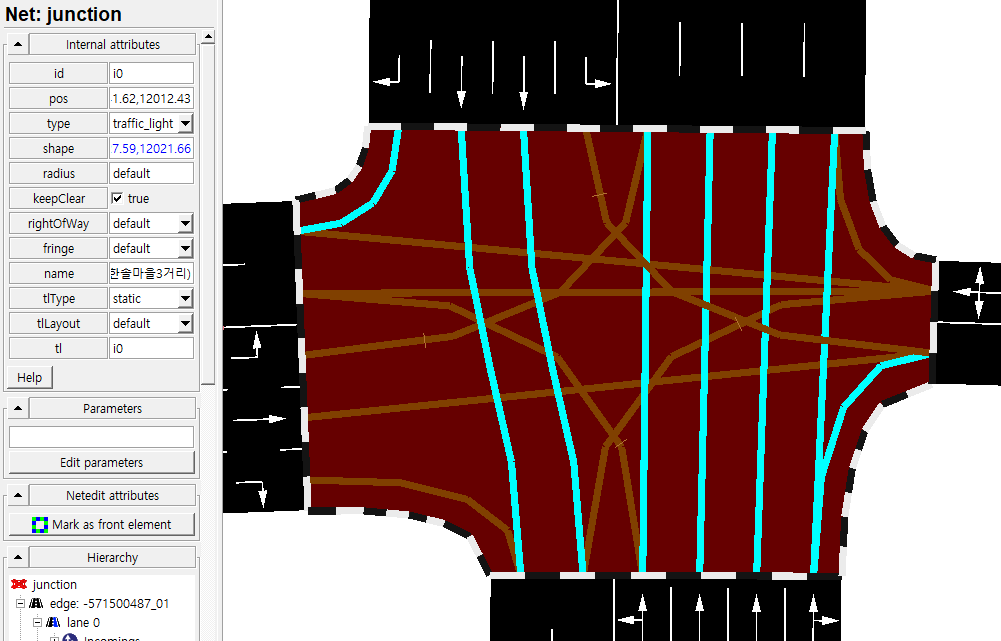

예상되는 초기화신호 `i0` : grrrgrrrgrrrrrgrr

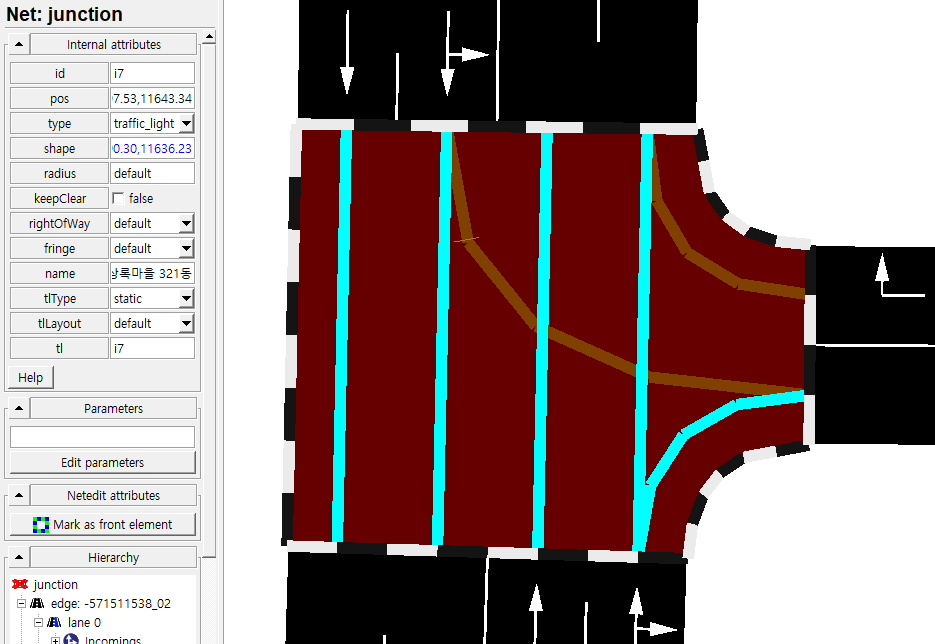

예상되는 초기화신호 `i7` : rrrggrr

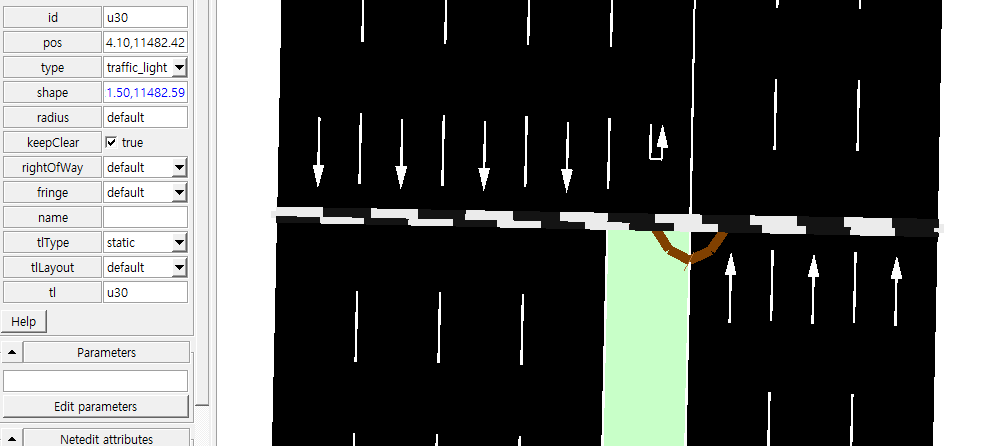

예상되는 초기화신호 `u30` : ggggrggg

In [45]:
# 1 잘 지정됨.
print(self.node2init['i0'])
print(self.node2init['i7'])
print(self.node2init['u30'])

['g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'g', 'r', 'r', 'r', 'r', 'r', 'g', 'r', 'r']
['r', 'r', 'r', 'g', 'g', 'r', 'r']
['g', 'g', 'g', 'g', 'r', 'g', 'g', 'g']


In [62]:
# 2 잘 매핑됨.
# 3 녹색신호가 잘 배정됨.
node_id = random.choice(self.sigtable.node_id.unique())
display(self.sigtable[self.sigtable.node_id==node_id][:5])
display(self.histids[self.histids.node_id==node_id][:5])

node_id  start_unix  phase_sumo  duration             state  \
12      i8  1704393010           0        24  grrrrrrrgGGGgrrr   
13      i8  1704393010           1        24  grrrrrrrgrrrgGGG   
14      i8  1704393010           2        17  grrrGGGrgrrrgGGr   
15      i8  1704393010           3        58  grrrGGGGgrrrgrrr   
16      i8  1704393010           4        17  gGGGrrrrgrrrgrrr   

              start_dt  
12 2024-01-05 03:30:10  
13 2024-01-05 03:30:10  
14 2024-01-05 03:30:10  
15 2024-01-05 03:30:10  
16 2024-01-05 03:30:10

inter_no node_id  start_unix  phas_A  phas_B  duration     inc_edge_A  \
12       201      i8  1704393010       1       1        24  -571500569_01   
13       201      i8  1704393010       2       2        24   571500618_02   
14       201      i8  1704393010       3       3        17   571500617_02   
15       201      i8  1704393010       4       4        58   571500617_02   
16       201      i8  1704393010       5       5        17   571500583_01   

      out_edge_A     inc_edge_B    out_edge_B  
12  571500583_02  -571500569_01  571500618_01  
13  571500583_02   571500618_02  571500617_01  
14  571500618_01   571500618_02  571500617_01  
15  571500618_01   571500617_02  571500569_01  
16  571500617_01   571500583_01  571500569_01

## 9. `set_timepoints`

In [53]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()
self.initialize_states()
self.assign_signals()
self.set_timepoints()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.


### 9.1. 입력데이터
- 입력 : `sigtable`
- 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
- 설명 : 초기화신호가 부여된 신호테이블

In [54]:
display(self.sigtable)

node_id  start_unix  phase_sumo  duration    state            start_dt
0       c30  1704393010           0        38   rrrrrr 2024-01-05 03:30:10
1       c30  1704393010           1        39   GGGGGG 2024-01-05 03:30:10
2       c30  1704393010           2        40   GGGGGG 2024-01-05 03:30:10
3       c30  1704393010           3        23   GGGGGG 2024-01-05 03:30:10
4        i2  1704393010           0        36  GGggGGG 2024-01-05 03:30:10
..      ...         ...         ...       ...      ...                 ...
475      i7  1704394050           3        19  rrrggrr 2024-01-05 03:47:30
476     u20  1704394050           0        34   ggrggg 2024-01-05 03:47:30
477     u20  1704394050           1        19   ggrggg 2024-01-05 03:47:30
478     u20  1704394050           2        63   ggGggg 2024-01-05 03:47:30
479     u20  1704394050           3        24   ggrggg 2024-01-05 03:47:30

[480 rows x 6 columns]

### 9.2 출력데이터
- 출력 : `Sigtable`
- 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
- 설명 : 시작시각과 종료시각이 지정된 신호테이블
- 출력 : `offsets`
- 설명 : 각 노드의 offset을 설정하는 딕셔너리. 이때, offset이란, 시뮬레이션시에 첫번째 태그가 시작되는 시점이다.

['c30', 'i0', 'i1', 'i2', 'i3', 'i6', 'i7', 'i8', 'i9', 'u00', 'u20', 'u30', 'u31', 'u32', 'u60']


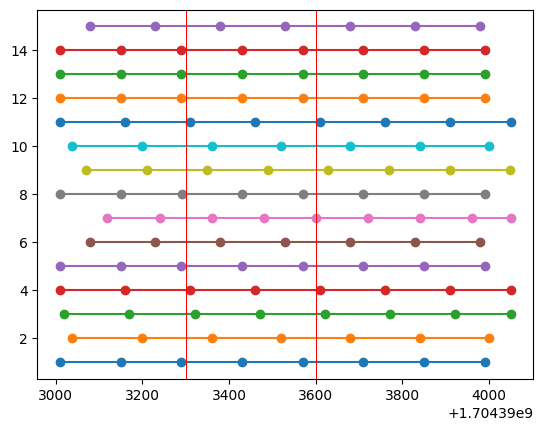

In [102]:
import matplotlib.pyplot as plt
k = 0
node_ids = []
for node_id, group in self.sigtable.groupby('node_id'):
    k += 1
    plt.plot(group.start_unix.unique(), [k] * len(group.start_unix.unique()), marker='o')
    plt.axvline(self.present_time - 300, c='r', linewidth=.5)
    plt.axvline(self.present_time, c='r', linewidth=.5)
    node_ids.append(node_id)
print(node_ids)

#### 상세한 설명
이전 데이터프레임인 `sigtable`의 시작유닉스는 위의 그림과 같다. y축은 각 `node_id`를 나타내고, 굵은 점으로 되어 있는 부분의 x좌표가 시작유닉스를 뜻함. 두 개의 빨간선은 각각 시뮬레이션 시작시각과 종료시각을 나타냄.
	- `present_time` = 오른쪽 빨간선
	- 시뮬레이션 시작시각 = `present_time` - 300
	- 시뮬레이션 종료시각 = `present_time`
	- `sigtable`의 하한(lower bound) = `present_time` - 600
    	- sigtable의 하한(lower bound) 설정 이유 :  하한을 시뮬레이션 시작시각(`present_time` - 300)으로 잡으면 시뮬레이션 구간 중에 신호가 없는 부분이 생기게된다. 따라서 일정 정도 앞선 시각을 하한으로 잡아야 한다. 이때, 인천시 기준으로 주기의 최댓값이 220임을 고려해 하한을 `present_time` - 600으로 잡았다.
    	- 하한이 `present_time` - 600으로 설정된 시점은 `merge_dfs`에서이고, 이전에 `make_rhists`에서 `present_time - subtractor//2(=1500)`으로 자른 것에서 한번 더 자른 것이다.
	- `sigtable`의 상한(upper bound) = `present_time` + 600
    	- 시뮬레이션 구간 중에 특정 교차로의 결측이 발생하는 경우 (결측이 발생하고 시뮬레이션 종료시점까지 데이터를 얻을 수 없는 경우) 신호가 적절히 생성될 수 없다. 이러한 오류를 방지하기 위해 `make_rhistory` 단계에서 `present_time + 600`에서 시작하는 한 주기동안의 신호이력을 만들어놓는다. 그러면 `make_rhistory` 단계에서는 `present_time`과 `present_time` + 600 사이 구간이 채워지게 된다. (참값판단프로세스. 정확하게는 결측치 처리.) 따라서 결과적으로 `sigtable`의 상한은 `present_time + 600`이 된다.
-  이만큼의 신호정보를 가지고 있으면 시뮬레이션 시간동안 정상적으로 시뮬레이션이 진행될 수 있다. 하지만, 한 신호파일(add.xml)에서 다른 신호파일(add.xml)로 넘어갈 때, phase 태그의 갯수가 달라서 오류가 날 수 있다. 한편, xml 파일의 용량은 최대한 작아야 한다. 즉, 다음 두 문제를 해결해야 한다.
	1) `phase` 태그의 갯수가 신호가 생성될 때마다 바뀌지 않도록 해야 한다.
	2) `phase` 태그의 갯수는 최대한 적을 수록 좋다.
- 한편
- 3) 시뮬레이션 기간의 모든 시점에서 신호가 부여되어야 한다
- 는 조건도 당연히 성립해야 한다.
- `sigtable` 단계에서 주기의 갯수가 일정하게 유지되어도 1)은 해결 가능하다. 즉, 노드별로 가능한 주기의 갯수의 최솟값(`num_cycles`)을 지정하고 `num_cycles`의 주기만큼만 남기면 된다.
- 예를 들어 설명하면, 교차로 `i0`의 주기가 각각 160, 170, 180, 190이다. 따라서 최소주기는 160이다. 300(5분)을 160으로 나눈 몫은 1인데, 거기에 2를 더해 3을 만든다. 이때 3이 노드id `i0`에 대한 `num_cycles`이다.
- 즉, `lsbs`(the last `start_unix` before `sim_start`)를 지정하고, `lsbs`에서 `num_cycles`개 만큼의 주기에 해당하는 주기만 살려서 `Sigtable`을 얻는다. 그러면, 원하던 목적에 부합한다. 1)이 성립하는 것은 `num_cycles`를 지정하는 데에서 당연하고, 2)는 가능한 최솟값은 아닐지라도, 어느 정도 최소의 값은 구한 셈이다.
- 3)도 설명가능하다. 수식으로 증명한 바 있지만 여기에서는 증명을 생략하겠다.
- 이상을 정리하면, 인접한 두 신호 파일 사이에 오류가 나지 않으면서, xml 파일의 크기를 어느 정도 최소화하면서 정리하면서 신호의 시작시각과 종료시각을 맞춘 셈이다.
- 그 결과로 아래와 같은 그림을 얻는다.

['c30', 'i0', 'i1', 'i2', 'i3', 'i6', 'i7', 'i8', 'i9', 'u00', 'u20', 'u30', 'u31', 'u32', 'u60']


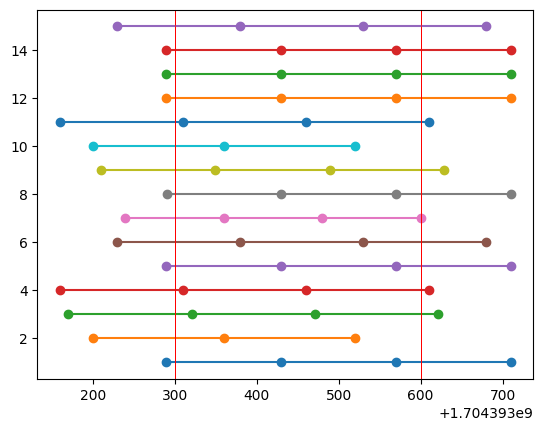

In [101]:
import matplotlib.pyplot as plt
k = 0
node_ids = []
for node_id, group in self.Sigtable.groupby('node_id'):
    k += 1
    plt.plot(group.start_unix.unique(), [k] * len(group.start_unix.unique()), marker='o')
    plt.axvline(self.present_time - 300, c='r', linewidth=.5)
    plt.axvline(self.present_time, c='r', linewidth=.5)
    node_ids.append(node_id)
print(node_ids)

In [61]:
lower_bound = self.sigtable.start_unix.min()
upper_bound = self.sigtable.start_unix.max()
print(lower_bound)
print(self.present_time)
print(upper_bound)
print(self.present_time - lower_bound)
print(upper_bound - self.present_time)

1704393010
1704393600
1704394050
590
450


### 9.3 검증요건
1. 인접한 두 신호파일에 대한 세이브로드시 `phase`태그의 갯수가 달라져서 생기는 오류를 방지할 수 있도록 시간이 세팅되었는가?
2. 시뮬레이션 기간의 모든 시점에서 신호가 부여될 수 있도록 시간이 세팅되었는가?
3. `offset`값이 제대로 설정되었는가?

### 9.4 검증

In [107]:
## 1, 2 : 위 그림으로 모두 검증되었음.
# 3 : i0의 경우 lsbs는 위의 그림에서 아래에서 두번째인 주황색 선분에서 세 개의 점들 중 가장 왼쪽에 있는 점임.
# 이것은 sim_start에 비해 100 앞서 있으므로 lsbs - sim_start는 -100으로 계산됨.
# 최종 add.xml 파일에서 i0는 세 번의 주기가 현시되고, 그림에 보이는 세 개 점들은 각 주기의 시작시간을 의미함.
# add.xml 파일에서 어떤 노드의 offset 값이 x이면 그 노드의 첫번째 phase 태그는 시뮬레이션 시작 이후 x초 후에 시작됨.
# 그런데 지금 상황은 시뮬레이션 시작보다 100초 앞서서 i0의 첫번째 phase 태그가 시작되어야 하므로 
# offset은 -100으로 설정되어야 함. 따라서 offset은 적절하게 설정되었음.
node_id = 'i0'
sim_start = self.present_time - 300
group = self.sigtable[self.sigtable.node_id==node_id]
lsbs = group[group['start_unix'] < sim_start]['start_unix'].max() # the last start_unix before sim_start
print(lsbs - sim_start)

-100


## 10. `assign_yellow_red`

In [69]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()
self.initialize_states()
self.assign_signals()
self.set_timepoints()
self.assign_red_yellow()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.


### 10.1. 입력데이터
- 입력 : `Sigtable`
- 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
- 설명 : 시작시각과 종료시각이 지정된 신호테이블

### 10.2 출력데이터
- 출력 : `SIGTABLE`
- 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
- 설명 : 황색시간과 적색시간이 지정된 신호테이블

In [96]:
display(self.SIGTABLE)

node_id  start_unix phase_sumo  duration      state            start_dt
0       c30  1704393290        0_g        33     rrrrrr 2024-01-05 03:34:50
1       c30  1704393290        0_y         4     rrrrrr 2024-01-05 03:34:50
2       c30  1704393290       1__r         1     rrrrrr 2024-01-05 03:34:50
0       c30  1704393290        1_g        34     GGGGGG 2024-01-05 03:34:50
1       c30  1704393290        1_y         4     GGGGGG 2024-01-05 03:34:50
..      ...         ...        ...       ...        ...                 ...
2       u60  1704393680       3__r         1  ggggggggr 2024-01-05 03:41:20
0       u60  1704393680        3_g        51  ggggggggr 2024-01-05 03:41:20
1       u60  1704393680        3_y         4  ggggggggr 2024-01-05 03:41:20
2       u60  1704393680       4__r         1  ggggggggr 2024-01-05 03:41:20
309     u60  1704393680        4_g        17  ggggggggr 2024-01-05 03:41:20

[684 rows x 6 columns]

### 10.3 검증요건
1. `g` -> `g` 사이에 `g`, `g`가 부여되었는가?
2. `r` -> `r` 사이에 `r`, `r`이 부여되었는가?
3. `G` -> `G` 사이에 `G`, `G`가 부여되었는가?
4. `G` -> `r` 사이에 `y`, `r`이 부여되었는가?
5. `r` -> `G` 사이에 `r`, `r`이 부여되었는가?
* 이 다섯 경우만 검증하면 됨. $|\{G, g, r\}^2|=9$이므로 가능한 경우의 수는 아홉가지이지만, g로 시작하는 경우에는 무조건 g로 끝나고 그 반대도 성립하기 때문에 4가지 경우는 제외할 수 있음.

### 10.4 검증

In [85]:
## 모두 검증되었음.
display(self.Sigtable[self.Sigtable.node_id=='i0'])
display(self.SIGTABLE[self.SIGTABLE.node_id=='i0'])

node_id  start_unix  phase_sumo  duration              state  \
98       i0  1704393200           0        37  gGGrgrrrgGGGGrgrr   
99       i0  1704393200           1        39  grrGgrrrgrrrrGgrr   
100      i0  1704393200           2        25  grrrgGGGgrrrrrgrr   
101      i0  1704393200           3        30  grrrgGGrgrrrrrgGr   
102      i0  1704393200           4        29  grrrgrrrgrrrrrgGG   
162      i0  1704393360           0        37  gGGrgrrrgGGGGrgrr   
163      i0  1704393360           1        39  grrGgrrrgrrrrGgrr   
164      i0  1704393360           2        25  grrrgGGGgrrrrrgrr   
165      i0  1704393360           3        30  grrrgGGrgrrrrrgGr   
166      i0  1704393360           4        29  grrrgrrrgrrrrrgGG   
228      i0  1704393520           0        37  gGGrgrrrgGGGGrgrr   
229      i0  1704393520           1        39  grrGgrrrgrrrrGgrr   
230      i0  1704393520           2        25  grrrgGGGgrrrrrgrr   
231      i0  1704393520           3        30  grrrgGGrgrrrrrgGr   
232      i0  1704393520           4        29  grrrgrrrgrrrrrgGG   

               start_dt  
98  2024-01-05 03:33:20  
99  2024-01-05 03:33:20  
100 2024-01-05 03:33:20  
101 2024-01-05 03:33:20  
102 2024-01-05 03:33:20  
162 2024-01-05 03:36:00  
163 2024-01-05 03:36:00  
164 2024-01-05 03:36:00  
165 2024-01-05 03:36:00  
166 2024-01-05 03:36:00  
228 2024-01-05 03:38:40  
229 2024-01-05 03:38:40  
230 2024-01-05 03:38:40  
231 2024-01-05 03:38:40  
232 2024-01-05 03:38:40

node_id  start_unix phase_sumo  duration              state  \
0        i0  1704393200        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393200        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393200       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393200        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393200        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393200       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393200        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393200        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393200       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393200        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393200        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393200       4__r         1  grrrgrrrgrrrrrgGr   
0        i0  1704393200        4_g        24  grrrgrrrgrrrrrgGG   
1        i0  1704393200        4_y         4  grrrgrrrgrrrrrgyy   
2        i0  1704393360       0__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393360        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393360       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393360        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393360       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393360        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393360       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393360        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393360        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393360       4__r         1  grrrgrrrgrrrrrgGr   
0        i0  1704393360        4_g        24  grrrgrrrgrrrrrgGG   
1        i0  1704393360        4_y         4  grrrgrrrgrrrrrgyy   
2        i0  1704393520       0__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393520        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393520       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393520        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393520       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393520        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393520       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393520        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393520        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393520       4__r         1  grrrgrrrgrrrrrgGr   
232      i0  1704393520        4_g        24  grrrgrrrgrrrrrgGG   

               start_dt  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 

## 11. `make_tl_file`

In [87]:
self = SignalGenerator()
self.present_time = int(datetime(2024, 1, 5, 3, 40).timestamp())
self.prepare_data()
self.process_history()
self.process_movement()
self.make_histids()
self.initialize_states()
self.assign_signals()
self.set_timepoints()
self.assign_red_yellow()

1. 데이터를 준비합니다.
1-1. 네트워크가 로드되었습니다.
1-2. 테이블들이 로드되었습니다.
2. 신호이력 테이블을 변환합니다.
3. 이동류정보 테이블을 변환합니다.
4. 통합 테이블을 생성합니다.


### 11.1. 입력데이터
- 입력 : `SIGTABLE`
- 컬럼 : 노드id, 시작유닉스, sumo현시번호, 현시시간, 신호, (시작일시)
- 설명 : 황색시간과 적색시간이 지정된 신호테이블

### 11.2 출력데이터
- 출력 : `sn_[timestamp].add.xml`
- 설명 : 신호파일

### 11.3 검증요건

1. `SIGTABLE`의 현시시간과 신호가 잘 반영되었는가?
2. `offset`이 제대로 반영되었는가?

### 11.4 검증

In [94]:
# 1 잘 반영됨
print(self.offsets)
self.SIGTABLE[self.SIGTABLE.node_id=='i0']


{'c30': -10, 'i0': -100, 'i1': -130, 'i2': -140, 'i3': -10, 'i6': -70, 'i7': -60, 'i8': -9, 'i9': -90, 'u00': -100, 'u20': -140, 'u30': -10, 'u31': -10, 'u32': -10, 'u60': -70}


node_id  start_unix phase_sumo  duration              state  \
0        i0  1704393200        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393200        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393200       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393200        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393200        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393200       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393200        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393200        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393200       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393200        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393200        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393200       4__r         1  grrrgrrrgrrrrrgGr   
0        i0  1704393200        4_g        24  grrrgrrrgrrrrrgGG   
1        i0  1704393200        4_y         4  grrrgrrrgrrrrrgyy   
2        i0  1704393360       0__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393360        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393360       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393360        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393360       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393360        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393360        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393360       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393360        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393360        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393360       4__r         1  grrrgrrrgrrrrrgGr   
0        i0  1704393360        4_g        24  grrrgrrrgrrrrrgGG   
1        i0  1704393360        4_y         4  grrrgrrrgrrrrrgyy   
2        i0  1704393520       0__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        0_g        32  gGGrgrrrgGGGGrgrr   
1        i0  1704393520        0_y         4  gyyrgrrrgyyyyrgrr   
2        i0  1704393520       1__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        1_g        34  grrGgrrrgrrrrGgrr   
1        i0  1704393520        1_y         4  grrygrrrgrrrrygrr   
2        i0  1704393520       2__r         1  grrrgrrrgrrrrrgrr   
0        i0  1704393520        2_g        20  grrrgGGGgrrrrrgrr   
1        i0  1704393520        2_y         4  grrrgGGygrrrrrgrr   
2        i0  1704393520       3__r         1  grrrgGGrgrrrrrgrr   
0        i0  1704393520        3_g        25  grrrgGGrgrrrrrgGr   
1        i0  1704393520        3_y         4  grrrgyyrgrrrrrgGr   
2        i0  1704393520       4__r         1  grrrgrrrgrrrrrgGr   
232      i0  1704393520        4_g        24  grrrgrrrgrrrrrgGG   

               start_dt  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:33:20  
0   2024-01-05 03:33:20  
1   2024-01-05 03:33:20  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:36:00  
0   2024-01-05 03:36:00  
1   2024-01-05 03:36:00  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 03:38:40  
1   2024-01-05 03:38:40  
2   2024-01-05 03:38:40  
0   2024-01-05 

In [89]:
strings = ['<additional>\n']
for node_id, group in self.SIGTABLE.groupby('node_id'):
    strings.append(f'    <tlLogic id="{node_id}" type="static" programID="{node_id}_prog" offset="{self.offsets[node_id]}">\n')
    for row in group.itertuples(index=True):
        duration = row.duration
        state = row.state
        strings.append(f'      <phase duration="{duration}" state="{state}"/>\n')
    strings.append('    </tlLogic>\n')
strings.append('</additional>')
strings = ''.join(strings)
print(strings)

<additional>
    <tlLogic id="c30" type="static" programID="c30_prog" offset="-10">
      <phase duration="33" state="rrrrrr"/>
      <phase duration="4" state="rrrrrr"/>
      <phase duration="1" state="rrrrrr"/>
      <phase duration="34" state="GGGGGG"/>
      <phase duration="4" state="GGGGGG"/>
      <phase duration="1" state="GGGGGG"/>
      <phase duration="35" state="GGGGGG"/>
      <phase duration="4" state="GGGGGG"/>
      <phase duration="1" state="GGGGGG"/>
      <phase duration="18" state="GGGGGG"/>
      <phase duration="4" state="yyyyyy"/>
      <phase duration="1" state="rrrrrr"/>
      <phase duration="33" state="rrrrrr"/>
      <phase duration="4" state="rrrrrr"/>
      <phase duration="1" state="rrrrrr"/>
      <phase duration="34" state="GGGGGG"/>
      <phase duration="4" state="GGGGGG"/>
      <phase duration="1" state="GGGGGG"/>
      <phase duration="35" state="GGGGGG"/>
      <phase duration="4" state="GGGGGG"/>
      <phase duration="1" state="GGGGGG"/>
      